# Import Lib & Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
import itertools
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from fastai.text import *

from nltk.corpus import reuters
import nltk
# nltk.download('wordnet')
import pandas as pd
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
# from yellowbrick.text import TSNEVisualizer
import warnings
warnings.filterwarnings("ignore")

In [3]:
import fastai
print(fastai.__version__)

1.0.61


In [ ]:
# import nltk
# nltk.download('all')
# !unzip /root/nltk_data/corpora/reuters.zip -d /root/nltk_data/corpora

In [5]:
# nltk.download('reuters')
# !unzip /root/nltk_data/corpora/reuters.zip -d /root/nltk_data/corpora

In [6]:
train_documents, train_categories = zip(*[(reuters.raw(i), reuters.categories(i)) for i in reuters.fileids() if i.startswith('training/')])
test_documents, test_categories = zip(*[(reuters.raw(i), reuters.categories(i)) for i in reuters.fileids() if i.startswith('test/')])

In [7]:
print("Number of training documents:", len(train_documents))
print("Number of testing documents:", len(test_documents))

Number of training documents: 7769
Number of testing documents: 3019


In [8]:
train_categories = [i[0] for i in train_categories]

In [9]:
test_categories = [i[0] for i in test_categories]

In [10]:
trainData = {"content": train_documents}
testData = {"content": test_documents}
trainDf = pd.DataFrame(trainData, columns=["content"])
trainDf['label'] = train_categories
testDf = pd.DataFrame(testData, columns=["content"])
testDf['label'] = test_categories

In [11]:
trainDf.label.value_counts()[0:10]

earn            2843
acq             1650
crude            370
interest         329
money-fx         266
trade            253
grain            218
corn             157
dlr              126
money-supply     125
Name: label, dtype: int64

In [12]:
trainDf = trainDf[trainDf.label.isin(['crude','interest','money-fx','trade','grain','money-supply'])]

In [13]:
testDf = testDf[testDf.label.isin(['crude','interest','money-fx','trade','grain','money-supply'])]

In [14]:
trainDf.shape, testDf.shape

((1561, 2), (584, 2))

In [15]:
# trainDf.to_excel('/content/drive/MyDrive/ColabData/trainDf.xlsx', index= False)

In [16]:
# wordnet_lemmatizer = WordNetLemmatizer()
# stemmer = PorterStemmer()
# stopwords = set(w.rstrip() for w in open(r"../input/reuters/reuters/reuters/stopwords"))

# def tokenize_lemma_stopwords(text):
#     text = text.replace("\n", " ")
#     tokens = nltk.tokenize.word_tokenize(text.lower()) # split string into words (tokens)
#     tokens = [t for t in tokens if t.isalpha()] # keep strings with only alphabets
#     tokens = [wordnet_lemmatizer.lemmatize(t) for t in tokens] # put words into base form
#     tokens = [stemmer.stem(t) for t in tokens]
#     tokens = [t for t in tokens if len(t) > 2] # remove short words, they're probably not useful
#     #tokens = [t for t in tokens if t not in stopwords] # remove stopwords
#     cleanedText = " ".join(tokens)
#     return cleanedText

# def dataCleaning(df):
#     data = df.copy()
#     data["content"] = data["content"].apply(tokenize_lemma_stopwords)
#     return data

# ULMFit Model

In [17]:
# Language model data
data_lm = TextLMDataBunch.from_df(train_df = trainDf,valid_df = testDf,  path = "",text_cols ='content', label_cols='label')
data_lm.show_batch()     

idx,text
0,"pct increase in the xxmaj december year and xxunk pct rise a year \n ago period , it said in its weekly statistical release . \n xxmaj total deposits rose to xxunk billion xxup n.z. xxmaj dlrs in xxmaj january \n compared with xxunk billion in xxmaj december and xxunk billion in \n xxmaj january 1986 . \n \n \n xxbos xxup canada xxup oil"
1,"savings and an excessive budget deficit -- would \n remain , "" the report said . \n xxup gatt economists said trade expansion would slow this year \n because of slower growth forecasts in xxmaj japan and some xxmaj west \n xxmaj european nations as they adjust production and xxunk to a \n low dollar , risk of higher xxup u.s. xxmaj inflation , concerns"
2,"under the government 's \n proposed xxmaj banking xxmaj bill now moving through parliament . \n 58 xxmaj japanese financial institutions are authorised to deal \n in xxmaj london , of which 29 are banks . xxmaj in xxmaj tokyo , 14 xxmaj london - based \n firms are authorised to do financial business , officials said . \n xxmaj the new financial services and"
3,"groups xxmaj bahrain , xxmaj kuwait , xxmaj oman , xxmaj qatar , xxmaj saudi xxmaj arabia \n and the xxmaj united xxmaj arab xxmaj emirates ( xxup uae ) . \n xxmaj the bank said the improvement would result from higher oil \n prices made possible by last xxmaj december 's xxup opec accord to restrain \n overall group production . \n xxmaj these"
4,"said the \n ministry has recently conducted a survey on foreign exchange \n transactions by institutional investors but declined to say if \n it was aimed at moderating their dollar sales . \n xxmaj however , financial market sources said they had heard the \n ministry has asked life insurance and securities firms to \n refrain from selling dollars , but they were unable"


In [18]:
# Classifier model data
data_clas = TextClasDataBunch.from_df(path = "", train_df = trainDf, valid_df = testDf, vocab=data_lm.train_ds.vocab, bs=32,text_cols ='content', label_cols='label')

In [19]:
data_lm.save('/content/drive/MyDrive/ColabData/ulmfit/data_lm.pkl')
data_clas.save('/content/drive/MyDrive/ColabData/ulmfit/data_clas.pkl')

## Train Language Model

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-02
Min loss divided by 10: 3.02E-02


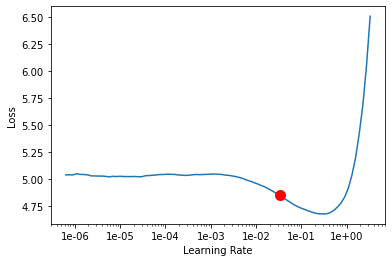

In [20]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)
#find the optimal learning rate & visualize it
learn.lr_find();
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr

In [21]:
min_grad_lr

0.03311311214825908

In [22]:
learn.fit_one_cycle(3,min_grad_lr, moms=(0.85,0.75))

epoch,train_loss,valid_loss,accuracy,time
0,3.798337,3.455342,0.343175,00:17
1,3.181480,3.302663,0.362906,00:17
2,2.606810,3.244983,0.371199,00:17


In [23]:
learn.unfreeze()
learn.fit_one_cycle(3, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.688941,3.337110,0.377591,00:23
1,2.388464,3.143053,0.407183,00:23
2,1.672716,3.250914,0.404782,00:22


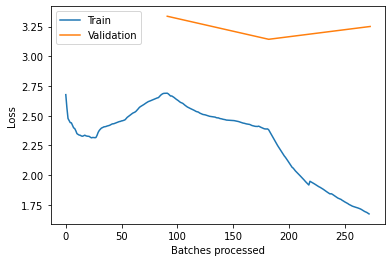

In [24]:
learn.recorder.plot_losses()

In [25]:
learn.fit_one_cycle(3, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.187536,3.328275,0.407292,00:23
1,1.063050,3.404253,0.403829,00:24
2,0.873326,3.461025,0.405952,00:23


In [27]:
TEXT = "My name is paras mal and I want to "
N_WORDS = 40
N_SENTENCES = 2
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))
#Save fine-tuned model for future use
learn.save_encoder('/content/drive/MyDrive/ColabData/ulmfit/fine_tuned_lang')

My name is paras mal and I want to  be sure that IEA 
  has made a final determination that the world oil prices will be 
  exceeded , IEA 
 
 
  xxbos API SAYS DISTILLATE STOCKS OFF 4.4 MLN BBLS
My name is paras mal and I want to  be sure that , if U.S. 
  Prime Minister business on a foreign basis , there is no chance of imminent 
  prime rate cuts , he said . 
  He told the House


## Train Classifier 

In [28]:
data_clas.vocab.itos = data_lm.vocab.itos
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('/content/drive/MyDrive/ColabData/ulmfit/fine_tuned_lang')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (1561 items)
x: TextList
xxbos xxup n.z. xxup trading xxup bank xxup deposit xxup growth xxup rises xxup slightly 
  xxmaj new xxmaj zealand 's trading bank seasonally 
  adjusted deposit growth rose 2.6 pct in xxmaj january compared with a 
  rise of 9.4 pct in xxmaj december , the xxmaj reserve xxmaj bank said . 
  xxmaj year - on - year total deposits rose 30.6 pct compared with a 
  26.3 pct increase in the xxmaj december year and xxunk pct rise a year 
  ago period , it said in its weekly statistical release . 
  xxmaj total deposits rose to xxunk billion xxup n.z. xxmaj dlrs in xxmaj january 
  compared with xxunk billion in xxmaj december and xxunk billion in 
  xxmaj january 1986 . 
 
 
 ,xxbos xxup canada xxup oil xxup exports xxup rise 20 xxup pct xxup in 1986 
  xxmaj canadian oil exports rose 20 pct in 1986 
  over the previous year to xxunk mln cubic meters , while oil 
  imports soared xxunk pct to xxunk mln cubic meter

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-03
Min loss divided by 10: 1.74E-02


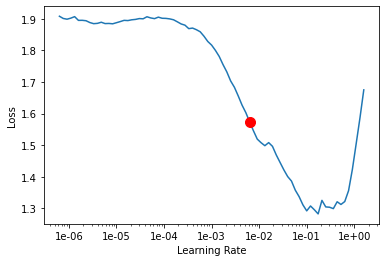

In [29]:
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr

In [30]:
learn.fit_one_cycle(4, min_grad_lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.984116,0.521373,0.820205,00:13
1,0.747396,0.418753,0.849315,00:12
2,0.585465,0.450403,0.863014,00:11
3,0.495450,0.410894,0.851027,00:12


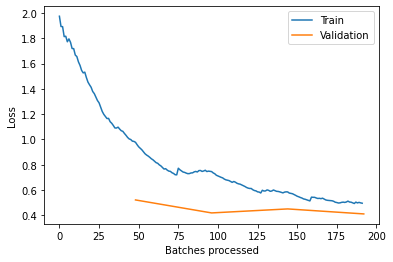

In [31]:
learn.recorder.plot_losses()

In [32]:
learn.freeze_to(-2)
learn.fit_one_cycle(3, slice(5e-3/2., 5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.507309,0.506599,0.833904,00:14
1,0.454056,0.299437,0.890411,00:14
2,0.371674,0.291405,0.893836,00:13


In [33]:
learn.freeze_to(-3)
learn.fit_one_cycle(3, slice(5e-3/2., 5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.307500,0.358518,0.888699,00:22
1,0.324699,0.296737,0.904110,00:23
2,0.238553,0.303950,0.904110,00:23


In [34]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(2e-3/100, 2e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.147566,0.288650,0.907534,00:29
1,0.120939,0.296933,0.905822,00:28


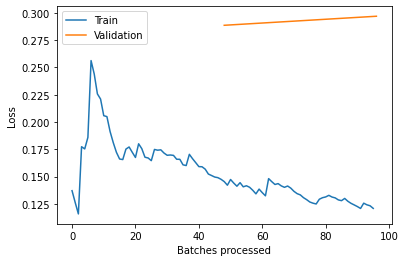

In [35]:
learn.recorder.plot_losses()

In [36]:
learn.export('/content/drive/MyDrive/ColabData/ulmfit/ULMfit_classifier_news_export')

In [37]:
# learn.load('ULMfit_classifier_news.pkl',)

In [38]:
# get predictions
preds, targets = learn.get_preds()

predictions = np.argmax(preds, axis = 1)
pd.crosstab(predictions, targets)

col_0,0,1,2,3,4,5
row_0,,,,,,
0,179,0,0,0,0,0
1,0,75,0,0,0,1
2,0,0,101,17,2,0
3,3,1,21,76,2,2
4,0,0,1,1,25,0
5,0,1,1,2,0,73


In [39]:
learn.show_results()

text,target,prediction
"xxbos xxup u.s. xxup markets xxup offer xxup xxunk xxup of xxup volcker xxup xxunk \n xxmaj today 's turmoil in the xxup u.s. xxmaj financial \n markets , with bond and stock prices xxunk in the dollar 's \n xxunk , is evidence of a major shift in investor xxunk that \n is likely to spell more turbulence ahead , economists said . \n",interest,money-fx
"xxbos xxup german xxup financial xxup policy xxup makers xxup in xxup xxunk xxup xxunk \n xxmaj karl xxmaj otto xxmaj poehl , head of xxmaj west xxmaj germany 's \n central bank , and xxmaj finance xxmaj minister xxmaj gerhard xxmaj stoltenberg are \n normally so much in agreement that some foreigners doubt the \n central bank 's xxunk . \n xxmaj but a",interest,interest
xxbos xxup deficit xxup cuts xxup seen xxup unable xxup to xxup xxunk xxup trade xxup deficit \n xxmaj financial analysts say they are \n pleased with congressional moves to trim next year 's federal \n budget deficit but believe the actions will do little to help \n improve the xxup u.s. trade deficit or xxunk the economy . \n xxmaj the xxmaj house of,trade,money-fx
"xxbos xxup bundesbank xxup credit xxup policy xxup changes xxup unlikely \n xxmaj the xxmaj bundesbank is unlikely to change \n credit policies when its central bank council meets on xxmaj thursday \n for its last session before the xxmaj venice summit , banking \n economists and money market dealers said . \n xxmaj the xxmaj bundesbank xxunk money market rates lower last month \n",interest,interest
"xxbos xxup asian xxup exporters xxup fear xxup damage xxup from xxup u.s.-japan xxup xxunk \n xxmaj mounting trade friction between the \n xxup u.s. xxmaj and xxmaj japan has raised fears among many of xxmaj asia 's exporting \n nations that the row could xxunk far - reaching economic \n damage , businessmen and officials said . \n xxmaj they told xxmaj reuter correspondents",trade,trade


In [40]:
doc = '''  Mounting trade friction between the
  U.S. And Japan has raised fears among many of Asia's exporting
  nations that the row could inflict far-reaching economic
  damage, businessmen and officials said.
      They told Reuter correspondents in Asian capitals a U.S.
  Move against Japan might boost protectionist sentiment in the
  U.S. And lead to curbs on American imports of their products.
      But some exporters said that while the conflict would hurt
  them in the long-run, in the short-term Tokyo's loss might be
  their gain.
      The U.S. Has said it will impose 300 mln dlrs of tariffs on
  imports of Japanese electronics goods on April 17, in
  retaliation for Japan's alleged failure to stick to a pact not
  to sell semiconductors on world markets at below cost.
      Unofficial Japanese estimates put the impact of the tariffs
  at 10 billion dlrs and spokesmen for major electronics firms
  said they would virtually halt exports of products hit by the
  new taxes.
      "We wouldn't be able to do business," said a spokesman for
  leading Japanese electronics firm Matsushita Electric
  Industrial Co Ltd &lt;MC.T>.
      "If the tariffs remain in place for any length of time
  beyond a few months it will mean the complete erosion of
  exports (of goods subject to tariffs) to the U.S.," said Tom
  Murtha, a stock analyst at the Tokyo office of broker &lt;James
  Capel and Co>.
      In Taiwan, businessmen and officials are also worried.
      "We are aware of the seriousness of the U.S. Threat against
  Japan because it serves as a warning to us," said a senior
  Taiwanese trade official who asked not to be named.
      Taiwan had a trade trade surplus of 15.6 billion dlrs last
  year, 95 pct of it with the U.S.
      The surplus helped swell Taiwan's foreign exchange reserves
  to 53 billion dlrs, among the world's largest.
      "We must quickly open our markets, remove trade barriers and
  cut import tariffs to allow imports of U.S. Products, if we
  want to defuse problems from possible U.S. Retaliation," said
  Paul Sheen, chairman of textile exporters &lt;Taiwan Safe Group>.
      A senior official of South Korea's trade promotion
  association said the trade dispute between the U.S. And Japan
  might also lead to pressure on South Korea, whose chief exports
  are similar to those of Japan.
      Last year South Korea had a trade surplus of 7.1 billion
  dlrs with the U.S., Up from 4.9 billion dlrs in 1985.
      In Malaysia, trade officers and businessmen said tough
  curbs against Japan might allow hard-hit producers of
  semiconductors in third countries to expand their sales to the
  U.S.
      In Hong Kong, where newspapers have alleged Japan has been
  selling below-cost semiconductors, some electronics
  manufacturers share that view. But other businessmen said such
  a short-term commercial advantage would be outweighed by
  further U.S. Pressure to block imports.
      "That is a very short-term view," said Lawrence Mills,
  director-general of the Federation of Hong Kong Industry.
      "If the whole purpose is to prevent imports, one day it will
  be extended to other sources. Much more serious for Hong Kong
  is the disadvantage of action restraining trade," he said.
      The U.S. Last year was Hong Kong's biggest export market,
  accounting for over 30 pct of domestically produced exports.
      The Australian government is awaiting the outcome of trade
  talks between the U.S. And Japan with interest and concern,
  Industry Minister John Button said in Canberra last Friday.
      "This kind of deterioration in trade relations between two
  countries which are major trading partners of ours is a very
  serious matter," Button said.
      He said Australia's concerns centred on coal and beef,
  Australia's two largest exports to Japan and also significant
  U.S. Exports to that country.
      Meanwhile U.S.-Japanese diplomatic manoeuvres to solve the
  trade stand-off continue.
      Japan's ruling Liberal Democratic Party yesterday outlined
  a package of economic measures to boost the Japanese economy.
      The measures proposed include a large supplementary budget
  and record public works spending in the first half of the
  financial year.
      They also call for stepped-up spending as an emergency
  measure to stimulate the economy despite Prime Minister
  Yasuhiro Nakasone's avowed fiscal reform program.
      Deputy U.S. Trade Representative Michael Smith and Makoto
  Kuroda, Japan's deputy minister of International Trade and
  Industry (MITI), are due to meet in Washington this week in an
  effort to end the dispute.
'''

doc = '''JAPAN GIVEN LITTLE HOPE OF AVOIDING U.S. SANCTIONS
  A top U.S. Official said Japan has little
  chance of convincing the U.S. To drop threatened trade
  sanctions, despite the efforts of a Japanese team that left for
  Washington today.
      Michael Armacost, Under Secretary of State for Political
  Affairs, was asked at a press conference whether Japan's moves
  to boost its domestic economy and open its markets could
  persuade the U.S. Not to impose tariffs on Japanese imports
  said, and replied: "...It is probably too early for the figures
  to demonstrate that the situation has turned around and to
  permit the result you have described."
      Armacost said the U.S. Hopes Japan will take steps to lift
  its domestic economy and reduce dependence on exports, remove
  barriers to imports and settle outstanding trade issues.
      "There are obvious problems at the moment in the trade area,
  but we do not wish those problems to divert attention from
  important areas of cooperation that continue to exist on
  security and political issues," he said.
      "The question is whether through cooperative actions between
  our governments we can reduce the (trade) imbalance or whether
  Congress takes action to reduce it through protectionist
  legislation," he said.
  

'''

# doc = '''The US is focused on finding a multilateral solution to a range of key issues related 
# to international taxation, including our concerns with digital services taxes,
# USTR Katherine Tai said, adding that Washington remained committed to reaching a consensus 
# on international tax issues through the Organisation for Economic Co-operation and Development (OECD) 
# and G20 processes.'''


In [41]:
results = learn.predict(doc)


In [42]:
results

(Category tensor(5),
 tensor(5),
 tensor([3.0788e-04, 3.2946e-04, 9.5174e-04, 3.9210e-04, 2.2627e-04, 9.9779e-01]))

In [43]:
decision = str(results[0])
probas = to_np(results[2])
classes_probas = {str(c):p for c,p in zip(learn.data.train_ds.y.classes, probas)}


In [44]:
classes_probas

{'crude': 0.0003078821,
 'grain': 0.00032945795,
 'interest': 0.0009517407,
 'money-fx': 0.00039209824,
 'money-supply': 0.00022627103,
 'trade': 0.9977926}

In [45]:
proc = learn.data.train_ds.x.processor[0]
tokens = proc.process_one(doc)


In [46]:
!pip install shap

     |████████████████████████████████| 358kB 7.8MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491621 sha256=6a86a1aaca0429b20892791e88dd0eacc90f35b3ef9cd4c1e063c32a9431fe55
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


In [47]:
import fastai, shap

In [48]:
batch  = data_clas.one_batch()

In [49]:
len(data_clas.vocab.stoi)

16580

In [50]:
len(data_clas.vocab.itos) 

8504

In [51]:
import torch
from torch import nn

# padded = nn.ConstantPad1d((batch[0].shape[1] - xb.shape[1], 0), 1)(xb)

In [52]:
data_all = []
for k in range(len(trainDf)):
  xb = torch.tensor([data_clas.train_ds[k][0].data])
  padded = nn.ConstantPad1d((batch[0].shape[1] - xb.shape[1], 0), 1)(xb)
  data_all.append(padded[0])
all_batch = torch.stack(data_all).to(device='cuda')

In [53]:
all_batch.shape

torch.Size([1561, 1359])

In [54]:
ULMexplainer = shap.GradientExplainer(learn.model[1].layers[-2],all_batch)

In [55]:
def process_doc(learn, doc):
    xb, yb = learn.data.one_item(doc)
    return xb
# def encode_doc(learn, doc):
#     xb = process_doc(learn, doc)
# # Reset initializes the hidden state
#     awd_lstm = learn.model[0]
#     awd_lstm.reset()
#     with torch.no_grad():
#         out = awd_lstm.eval()(xb)
#     # Return raw output, for last RNN, on last token in sequence
#     return out[0][2][0].max(0)

In [56]:
xb = process_doc(learn, doc)

In [57]:
xb.shape

torch.Size([1, 279])

In [58]:
import torch
from torch import nn

padded = nn.ConstantPad1d((batch[0].shape[1] - xb.shape[1], 0), 1)(xb)
padded

tensor([[ 1,  1,  1,  ..., 17, 12, 36]], device='cuda:0')

In [105]:
shap_values,indexes =  ULMexplainer.shap_values(padded, ranked_outputs=50,rseed=0)

In [106]:
count = 0
for  x , ind, label in zip(padded,indexes,batch[1]):
    x = x.cpu() # move to CPU
    words = np.array(data_clas.valid_dl.vocab.itos)[x[ind]]
    weight = []
    for idx, j in enumerate(ind):
        weight.append(shap_values[idx][count][j])
    count +=1
    print(words, label)
    print(weight)

['convincing' 'armacost' 'armacost' 'avoiding' 'obvious' 'exist' 'turned' 'team' 'permit' 'persuade' 'remove'
 'described' 'wish' 'settle' 'michael' 'attention' 'replied' 'cooperative' 'imbalance' 'moment' 'lift' 'actions'
 'steps' 'dependence' 'affairs' 'takes' 'hopes' 'outstanding' 'threatened' 'governments' 'barriers' 'chance' 'impose'
 'hope' 'left' 'security' 'important' 'protectionist' 'moves' 'question' 'press' 'top' 'cooperation' 'despite'
 'situation' 'political' 'political' 'you' 'probably' 'sanctions'] tensor(5)
[6942.165, 5437.245, 5201.65, 5155.235, 4239.78, 3904.98, 2682.57, 2548.5, 2366.905, 2458.92, 1959.7, 2083.74, 1890.97, 1817.63, 1823.19, 1464.705, 1297.775, 1222.855, 970.315, 1015.755, 997.7, 892.825, 1016.235, 848.95, 1047.28, 832.17, 875.125, 856.205, 978.085, 628.615, 735.575, 843.805, 743.76, 811.095, 764.94, 288.15, 225.025, 185.42, 538.425, 283.355, 451.485, 552.67, 384.83, 340.865, 368.245, 440.455, 100.135, 166.025, 260.94, 438.235]


In [107]:
# data_clas.valid_dl.vocab.stoi

In [108]:
# words = data_clas.valid_dl.vocab.stoi
# num2word = {}
# for w in words.keys():
#     num2word[words[w]] = w
# sentence_words = np.stack(np.array(list(map(lambda x: num2word.get(x, "NONE"),indexes.cpu().detach().numpy()[0]))) )


In [109]:
# len(sentence_words)

In [110]:
# shap.initjs()
# # y_pred = trained_model.predict(sentence_test)
# # ind = np.argmax(y_pred)
# # print('Actual Category: %s, Predict Category: %s' % (Y_test[0], y_pred[0]))


In [111]:
# learn.data.vocab.textify(padded[0])

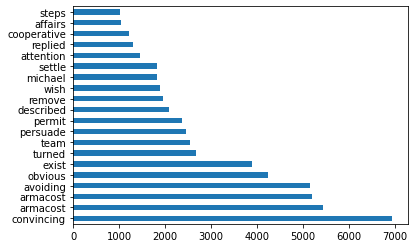

In [112]:
feat_importances = pd.Series(weight, index=words)
feat_importances.nlargest(20).plot(kind='barh')

# ULMFit embedding Calcualtion 

**xxbos**: Begining of a sentence <br>
**xxfld**: Represent separate parts of a document like title, summary etc., each one will get a separate field and so they will get numbered (e.g. xxfld 1, xxfld 2).<br>
**xxup**: If there's something in all caps, it gets lower cased and a token called xxup will get added to it. Words that are fully capitalized, such as “I AM SHOUTING”, are tokenized as “xxup i xxup am xxup shouting“<br>
**xxunk**: token used instead of an uncommon word.<br>
**xxmaj**: token indicates that there is capitalization of the word. “The” will be tokenized as “xxmaj the“.<br>
**xxrep**: token indicates repeated word, if you have 29 ! in a row, (i.e. xxrep 29 !).

In [ ]:
def get_normalized_embeddings():
    net = learn.model
    encoder = net[0]
    enc = list(encoder.children())[0]
    w = enc.encoder.weight
    return w

In [ ]:
def most_similar(token, embs):
    idx = data_lm.vocab.itos.index(token)
    sims = (embs[idx] @ embs.t()).cpu().detach().numpy()

    print(f'Similar to: {token}')
    for sim_idx in np.argsort(sims)[::-1][1:11]:
        print(f'{data_lm.vocab.itos[sim_idx]:<30}{sims[sim_idx]:.02f}')

In [ ]:
embs = get_normalized_embeddings()

In [ ]:
most_similar('armacost', embs)

Similar to: armacost
149.80                        27.09
informed                      25.76
maekawa                       25.69
telephoned                    23.49
roughly                       22.64
caputo                        22.54
houlder                       22.34
42,000                        22.09
eve                           22.02
kansai                        21.85


In [ ]:
learn.summary()